## **1. Install rdkit**

## **2. Delaney's solubility dataset**
We use this dataset to predict solublity  of a drug by using other parameters in the dataset. Solublity is an important physical-chemical property, and an important part of drug design.
### **2.1. Download the dataset**
### **2.2. Read in the dataset**

In [1]:
import pandas as pd

In [2]:
sol = pd.read_csv('delaney.csv')
sol.head()

,Compound ID,measured log(solubility:mol/L),ESOL predicted log(solubility:mol/L),SMILES
0,"1,1,1,2-Tetrachloroethane",-2.18,-2.794,ClCC(Cl)(Cl)Cl
1,"1,1,1-Trichloroethane",-2.00,-2.232,CC(Cl)(Cl)Cl
2,"1,1,2,2-Tetrachloroethane",-1.74,-2.549,ClC(Cl)C(Cl)Cl
3,"1,1,2-Trichloroethane",-1.48,-1.961,ClCC(Cl)Cl
4,"1,1,2-Trichlorotrifluoroethane",-3.04,-3.077,FC(F)(Cl)C(F)(Cl)Cl


### **2.3. Examining the SMILES data**

Chemical structures are encoded by a string of text known as **SMILES** which is an acronym for **Simplified Molecular-Input Line-Entry System**.

In [3]:
sol.SMILES

0                                    ClCC(Cl)(Cl)Cl
1                                      CC(Cl)(Cl)Cl
2                                    ClC(Cl)C(Cl)Cl
3                                        ClCC(Cl)Cl
4                               FC(F)(Cl)C(F)(Cl)Cl
                           ...                     
1139                   CNC(=O)C(C)SCCSP(=O)(OC)(OC)
1140          CC1(OC(=O)N(C1=O)c2cc(Cl)cc(Cl)c2)C=C
1141         CC(=O)CC(c1ccccc1)c3c(O)c2ccccc2oc3=O 
1142    Cc1cccc(C)c1NC(=O)c2cc(c(Cl)cc2O)S(N)(=O)=O
1143                         CNC(=O)Oc1cc(C)cc(C)c1
Name: SMILES, Length: 1144, dtype: object

## **3. Calculate molecular descriptors in rdkit**

### **3.1. Convert list of molecules to rdkit object**

In [4]:
from rdkit import Chem

In [5]:
mol_list= []
for element in sol.SMILES:
  mol = Chem.MolFromSmiles(element)
  mol_list.append(mol)

In [6]:
len(mol_list)

1144

In [7]:
mol_list[:5]

### **3.2. Calculate molecular descriptors**

To predict **LogS** (log of the aqueous solubility), the study by Delaney makes use of 4 molecular descriptors:
1. **cLogP** *(Octanol-water partition coefficient)*
2. **MW** *(Molecular weight)*
3. **RB** *(Number of rotatable bonds)*
4. **AP** *(Aromatic proportion = number of aromatic atoms / total number of heavy atoms)*

Unfortunately, rdkit readily computes the first 3. As for the AP descriptor, we will calculate this by manually computing the ratio of the *number of aromatic atoms* to the *total number of heavy atoms* which rdkit can compute.

#### **3.2.1. LogP, MW and RB**

In [8]:
import numpy as np
from rdkit.Chem import Descriptors

In [9]:
def generate(smiles, verbose=False):

    moldata= []
    for elem in smiles:
        mol=Chem.MolFromSmiles(elem) 
        moldata.append(mol)
       
    baseData= np.arange(1,1)
    i=0  
    for mol in moldata:        
       
        desc_MolLogP = Descriptors.MolLogP(mol)
        desc_MolWt = Descriptors.MolWt(mol)
        desc_NumRotatableBonds = Descriptors.NumRotatableBonds(mol)
           
        row = np.array([desc_MolLogP,
                        desc_MolWt,
                        desc_NumRotatableBonds])   
    
        if(i==0):
            baseData=row
        else:
            baseData=np.vstack([baseData, row])
        i=i+1      
    
    columnNames=["MolLogP","MolWt","NumRotatableBonds"]   
    descriptors = pd.DataFrame(data=baseData,columns=columnNames)
    
    return descriptors

In [10]:
df = generate(sol.SMILES)
df.head()

,MolLogP,MolWt,NumRotatableBonds
0,2.5954,167.850,0.0
1,2.3765,133.405,0.0
2,2.5938,167.850,1.0
3,2.0289,133.405,1.0
4,2.9189,187.375,1.0


#### **3.2.2. Aromatic proportion**

##### 3.2.1.1. Number of aromatic atoms

Here, we will create a custom function to calculate the **Number of aromatic atoms**. With this descriptor we can use it to subsequently calculate the AP descriptor.

In [11]:
def AromaticAtoms(m):
  aromatic_atoms = [m.GetAtomWithIdx(i).GetIsAromatic() for i in range(m.GetNumAtoms())]
  aa_count = []
  for i in aromatic_atoms:
    if i==True:
      aa_count.append(1)
  sum_aa_count = sum(aa_count)
  return sum_aa_count

Computing for molecules in the entire dataset.

In [12]:
desc_AromaticAtoms = [AromaticAtoms(element) for element in mol_list]
np.array(desc_AromaticAtoms)

array([ 0,  0,  0, ..., 16, 12,  6])

##### 3.2.1.2. **Number of heavy atoms**

Here, we will use an existing function for calculating the Number of heavy atoms.

Computing for molecules in the entire dataset.

In [13]:
desc_HeavyAtomCount = [Descriptors.HeavyAtomCount(element) for element in mol_list]
np.array(desc_HeavyAtomCount)

array([ 6,  5,  6, ..., 23, 23, 13])

##### **3.2.1.3. Computing the Aromatic Proportion (AP) descriptor**

Computing for molecules in the entire dataset.

In [14]:
desc_AromaticProportion = [AromaticAtoms(element)/Descriptors.HeavyAtomCount(element) for element in mol_list]
np.array(desc_AromaticProportion)

array([0.        , 0.        , 0.        , ..., 0.69565217, 0.52173913,
       0.46153846])

In [15]:
df_desc_AromaticProportion = pd.DataFrame(desc_AromaticProportion, columns=['AromaticProportion'])
df_desc_AromaticProportion

,AromaticProportion
0,0.000000
1,0.000000
2,0.000000
3,0.000000
4,0.000000
...,...
1139,0.000000
1140,0.333333
1141,0.695652
1142,0.521739


### **3.3. X matrix (Combining all computed descriptors into 1 dataframe)**

In [16]:
df.head()

,MolLogP,MolWt,NumRotatableBonds
0,2.5954,167.850,0.0
1,2.3765,133.405,0.0
2,2.5938,167.850,1.0
3,2.0289,133.405,1.0
4,2.9189,187.375,1.0


In [17]:
df_desc_AromaticProportion.head(10)

,AromaticProportion
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0
5,0.0
6,0.0
7,0.0
8,0.6
9,0.6


Let's combine the 2 dataframes to produce the **X** matrix

In [18]:
X = pd.concat([df,df_desc_AromaticProportion], axis=1)
X.head(10)

,MolLogP,MolWt,NumRotatableBonds,AromaticProportion
0,2.5954,167.850,0.0,0.0
1,2.3765,133.405,0.0,0.0
2,2.5938,167.850,1.0,0.0
3,2.0289,133.405,1.0,0.0
4,2.9189,187.375,1.0,0.0
5,1.8100,98.960,0.0,0.0
6,1.9352,96.944,0.0,0.0
7,1.4054,118.176,4.0,0.0
8,4.3002,215.894,0.0,0.6
9,2.5654,132.206,0.0,0.6


### **3.4. Y matrix**

In [19]:
sol.head()

,Compound ID,measured log(solubility:mol/L),ESOL predicted log(solubility:mol/L),SMILES
0,"1,1,1,2-Tetrachloroethane",-2.18,-2.794,ClCC(Cl)(Cl)Cl
1,"1,1,1-Trichloroethane",-2.00,-2.232,CC(Cl)(Cl)Cl
2,"1,1,2,2-Tetrachloroethane",-1.74,-2.549,ClC(Cl)C(Cl)Cl
3,"1,1,2-Trichloroethane",-1.48,-1.961,ClCC(Cl)Cl
4,"1,1,2-Trichlorotrifluoroethane",-3.04,-3.077,FC(F)(Cl)C(F)(Cl)Cl


Assigning the second column (index 1) to the Y matrix

In [20]:
Y = sol.iloc[:,1]
Y.head()

0   -2.18
1   -2.00
2   -1.74
3   -1.48
4   -3.04
Name: measured log(solubility:mol/L), dtype: float64

---

## **Data split**

In [21]:
from sklearn.model_selection import train_test_split

In [22]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

## **1. Linear Regression Model**

In [23]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

In [24]:
model = linear_model.LinearRegression()
model.fit(X_train, Y_train)

LinearRegression()

### Predicting X_test

In [25]:
Y_pred_test = model.predict(X_test)

In [26]:
print('Coefficients:', model.coef_)
print('Intercept:', model.intercept_)
print('Mean squared error (MSE): %.2f'
      % mean_squared_error(Y_test, Y_pred_test))
print('Coefficient of determination (R^2): %.2f'
      % r2_score(Y_test, Y_pred_test))

Coefficients: [-0.77708336 -0.00624778 -0.00286335 -0.39617685]
Intercept: 0.2791162942618204
Mean squared error (MSE): 1.04
Coefficient of determination (R^2): 0.77


### **Quick check of the variable dimensions of Train and Test sets**

In [27]:
Y_train.shape

(915,)

In [28]:
Y_test.shape, Y_pred_test.shape

((229,), (229,))

### Visulaizing

C:\Users\iyera\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
C:\Users\iyera\anaconda3\lib\site-packages\matplotlib\axes\_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]


Text(0.5, 0, 'Experimental LogS')

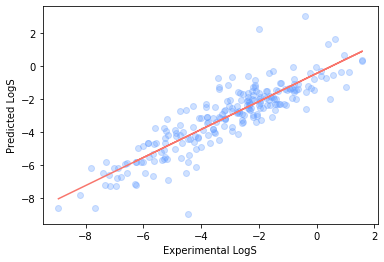

In [29]:
import matplotlib.pyplot as plt

plt.scatter(Y_test, Y_pred_test, c="#619CFF", alpha=0.3)

z = np.polyfit(Y_test, Y_pred_test, 1)
p = np.poly1d(z)
plt.plot(Y_test, p(Y_test), "#F8766D")

plt.ylabel('Predicted LogS')
plt.xlabel('Experimental LogS')

## **2. Ridge Regression Model**

In [30]:
alphas = 10**np.linspace(5,-5,100)*0.5

In [31]:
from sklearn.linear_model import Ridge, RidgeCV

In [32]:
ridge = Ridge(normalize = True)
mse = []
r2_ridge = []
for a in alphas:
    ridge.set_params(alpha = a)
    ridge.fit(X_train, Y_train)
    pred = ridge.predict(X_test)
    mse.append(mean_squared_error(Y_test, pred))
    r2_ridge.append(r2_score(Y_test, pred))

### Finding Best Value of Alpha

Text(0, 0.5, 'R2')

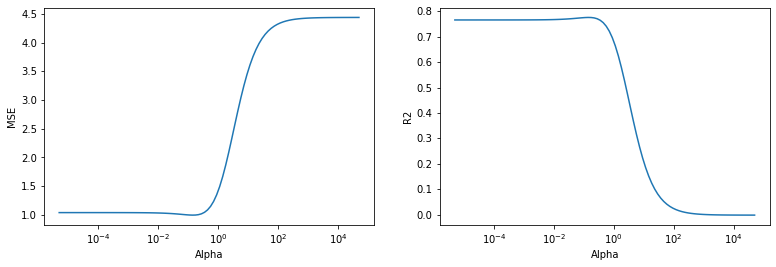

In [33]:
plt.figure(figsize=(13, 4))
plt.subplot(1,2,1)
ax = plt.gca()
ax.plot(alphas, mse)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('Alpha')
plt.ylabel('MSE')

plt.subplot(1,2,2)
ax = plt.gca()
ax.plot(alphas, r2_ridge)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('Alpha')
plt.ylabel('R2')

### **Using Cross Validation**

In [34]:
ridgecv = RidgeCV(alphas = alphas, scoring = 'neg_mean_squared_error', normalize = True)
ridgecv.fit(X_train, Y_train)
ridgecv.alpha_

0.006765238872899038

In [35]:
ridge = Ridge(alpha = ridgecv.alpha_, normalize = True)
ridge.fit(X_train, Y_train)
pred = ridge.predict(X_test)
print('Coefficients:', ridge.coef_)
print('Intercept:', ridge.intercept_)
print('Mean squared error (MSE): %.2f'
      % mean_squared_error(Y_test, pred))
print('Coefficient of determination (R^2): %.2f'
      % r2_score(Y_test, pred))

Coefficients: [-0.7714429  -0.00623741 -0.0040807  -0.40343597]
Intercept: 0.26855935447173973
Mean squared error (MSE): 1.04
Coefficient of determination (R^2): 0.77


## **3. Decision Tree Model**

In [36]:
from sklearn.tree import DecisionTreeRegressor

In [37]:
dtree = DecisionTreeRegressor()
dtree.fit(X_train, Y_train)

DecisionTreeRegressor()

In [38]:
pred = dtree.predict(X_test)
print('Mean squared error (MSE): %.2f'
      % mean_squared_error(Y_test, pred))
print('Coefficient of determination (R^2): %.2f'
      % r2_score(Y_test, pred))

Mean squared error (MSE): 0.77
Coefficient of determination (R^2): 0.83


## **Reference**

1. John S. Delaney. [ESOL:  Estimating Aqueous Solubility Directly from Molecular Structure](https://pubs.acs.org/doi/10.1021/ci034243x). ***J. Chem. Inf. Comput. Sci.*** 2004, 44, 3, 1000-1005.

2. Pat Walters. [Predicting Aqueous Solubility - It's Harder Than It Looks](http://practicalcheminformatics.blogspot.com/2018/09/predicting-aqueous-solubility-its.html). ***Practical Cheminformatics Blog***

3. Bharath Ramsundar, Peter Eastman, Patrick Walters, and Vijay Pande. [Deep Learning for the Life Sciences: Applying Deep Learning to Genomics, Microscopy, Drug Discovery, and More](https://learning.oreilly.com/library/view/deep-learning-for/9781492039822/), O'Reilly, 2019.

4. [Supplementary file](https://pubs.acs.org/doi/10.1021/ci034243x) from Delaney's ESOL:  Estimating Aqueous Solubility Directly from Molecular Structure.